The purpose of this notebook is to work through an example on single-cell data integration - specifically RNA-sequencing data integration (unimodal data), and how to evaluate the performance of RNA-sequencing integration.

We'll be using the scanpy library (https://scanpy.readthedocs.io/en/stable/) and the data will be imported in AnnData format (https://anndata.readthedocs.io/en/latest/).

We'll work with two batches (samples) of blood cell data processed at different centers. We'll examine the batch (technical effects) and integrate the data using the Harmony method (https://www.nature.com/articles/s41592-019-0619-0). 

Let's start by loading some libraries we'll need for the analysis

In [2]:
import os

import numpy as np 
import pandas as pd
import scanpy as sc 
import anndata as ann

Let's load the two batches of blood cell data using the scanpy library (which interfaces with anndata)

In [3]:
os.chdir("../data/")
pbmc_1 = sc.read_h5ad("rna/tran_exp_5/tran_exp5_pbmc_batch1.h5ad")
pbmc_2 = sc.read_h5ad("rna/tran_exp_5/tran_exp5_pbmc_batch2.h5ad")

Let's examine the data structure very quickly - anndata formats have three main components - .obs (cell-level metadata), .var (gene/feature-level metadata), and .X (the actual counts)

In [4]:
pbmc_1.X

<8098x33694 sparse matrix of type '<class 'numpy.float64'>'
	with 11576835 stored elements in Compressed Sparse Row format>

In [10]:
pbmc_1.shape

(8098, 33694)

In [8]:
pbmc_1.obs

,barcode,Sample,n_counts,n_genes,louvain,anno,Method,CellType,batch,celltype
data_3p-AAACCTGAGCATCATC-0,data_3p-AAACCTGAGCATCATC-0,data_3p,2394,871,9,B cell,10X_3prime,B cell,batch_1,B cell
data_3p-AAACCTGAGCTAGTGG-0,data_3p-AAACCTGAGCTAGTGG-0,data_3p,4520,1316,5,CD4 T cell,10X_3prime,CD4 T cell,batch_1,CD4 T cell
data_3p-AAACCTGCACATTAGC-0,data_3p-AAACCTGCACATTAGC-0,data_3p,2788,898,1,CD4 T cell,10X_3prime,CD4 T cell,batch_1,CD4 T cell
data_3p-AAACCTGCACTGTTAG-0,data_3p-AAACCTGCACTGTTAG-0,data_3p,4667,1526,0,Monocyte_CD14,10X_3prime,Monocyte_CD14,batch_1,Monocyte_CD14
data_3p-AAACCTGCATAGTAAG-0,data_3p-AAACCTGCATAGTAAG-0,data_3p,4440,1495,0,Monocyte_CD14,10X_3prime,Monocyte_CD14,batch_1,Monocyte_CD14
...,...,...,...,...,...,...,...,...,...,...
data_3p-TTTGTCATCATGTCCC-0,data_3p-TTTGTCATCATGTCCC-0,data_3p,3141,1176,4,CD8 T cell,10X_3prime,CD8 T cell,batch_1,CD8 T cell
data_3p-TTTGTCATCCGATATG-0,data_3p-TTTGTCATCCGATATG-0,data_3p,5401,1379,4,CD8 T cell,10X_3prime,CD8 T cell,batch_1,CD8 T cell
data_3p-TTTGTCATCGTCTGAA-0,data_3p-TTTGTCATCGTCTGAA-0,data_3p,6081,1802,0,Monocyte_CD14,10X_3prime,Monocyte_CD14,batch_1,Monocyte_CD14
data_3p-TTTGTCATCTCGAGTA-0,data_3p-TTTGTCATCTCGAGTA-0,data_3p,3970,1317,7,CD8 T cell,10X_3prime,CD8 T cell,batch_1,CD8 T cell


In [9]:
pbmc_1.var

,gene
RP11-34P13.3,RP11-34P13.3
FAM138A,FAM138A
OR4F5,OR4F5
RP11-34P13.7,RP11-34P13.7
RP11-34P13.8,RP11-34P13.8
...,...
AC233755.2,AC233755.2
AC233755.1,AC233755.1
AC240274.1,AC240274.1
AC213203.1,AC213203.1


As we can see, the counts are stored in a compressed format. The counts are in the form of cell x gene - where for each cell, we have the RNA counts across all genes. If we need to view them, we can convert them to dense format using `adata.X.todense()`. We won't do this here to save some disk space. The .obs dataframe object contains metadata for the cells, including what batch they come from (`batch`) and which expert annotated cell-type (class) they belong to (`cell-type`)

Now let's go ahead and begin examining the data and the technical effects that are present. We'll start by concatenating the two datasets together into one anndata object. This will be okay, because we have the `batch` metadata covariate in the .obs frame to tell us which batch which cells belong to. 

We'll call the `ann.concat` function, which takes in a list of samples to concatenate. To do this concatenation, the samples must share the same features. This means that the `.var` attribute of both samples must be equal. 

In [6]:
pbmc_concat = ann.concat([pbmc_1, pbmc_2]) 

In [7]:
pbmc_concat

AnnData object with n_obs × n_vars = 15476 × 33694
    obs: 'barcode', 'Sample', 'n_counts', 'n_genes', 'louvain', 'anno', 'Method', 'CellType', 'batch', 'celltype'

Now we can start analyzing the data. To clearly show that there is a technical effect present between the samples, we'll embed the data as-is without doing any horizontal integration. 

We'll perform the following steps to embed the data and then visualize the embedding using the UMAP (Uniform Manifold Approximation and Projection) algorithm (https://arxiv.org/abs/1802.03426):

1. Normalize the counts across cells
2. Log(1+x) transform the counts for numerical stability
3. Determine the highly-variable genes (this is a feature-selection step - pick the most informative genes)
4. Standardize the counts and do a 20-dimensional principal component analysis (PCA) reduction (this standardization is taken care of by scanpy)
5. Using the 20 PCA dimensions, do a UMAP reduction into a 2-dimensional space for visualization.
    - 5A. First, using PCA, create a neighborhood graph of the data (to be used by UMAP)
    - 5B. Use the neighborhood graph to embed the data into a two dimensional space using the UMAP algorithm.
6. Visualize the UMAP using the various cell-level metadata (including batch and cell-type)

We'll perform these steps sequentially so you can see which functions are used for each 

In [8]:
sc.pp.normalize_total(pbmc_concat, target_sum=1e4) # Normalize total cell counts to 10000 for all cells
sc.pp.log1p(pbmc_concat) # Log (1+x) transform the counts for numerical stability
sc.pp.highly_variable_genes(pbmc_concat, flavor="seurat") # Get the highly-variable genes (feature selection)
sc.pp.pca(pbmc_concat, n_comps=20) # Perform PCA reduction of the data
sc.pp.neighbors(pbmc_concat, n_neighbors=15) # Get the neighborhood graph of the PCA space
sc.tl.umap(pbmc_concat) # Use the neighborhood graph to get the UMAP coordinates

Now let's examine the data using the UMAP representation - we'll look at the batch and cell-type covariates

/h/hmaan/miniconda3/envs/single_cell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Sample' as categorical
/h/hmaan/miniconda3/envs/single_cell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Method' as categorical
/h/hmaan/miniconda3/envs/single_cell_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and wi

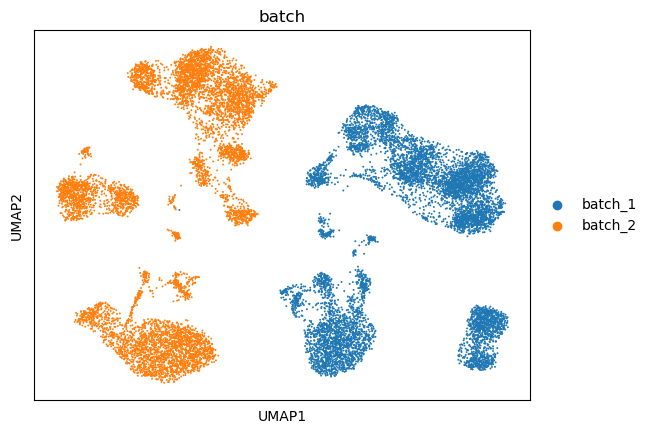

/h/hmaan/miniconda3/envs/single_cell_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


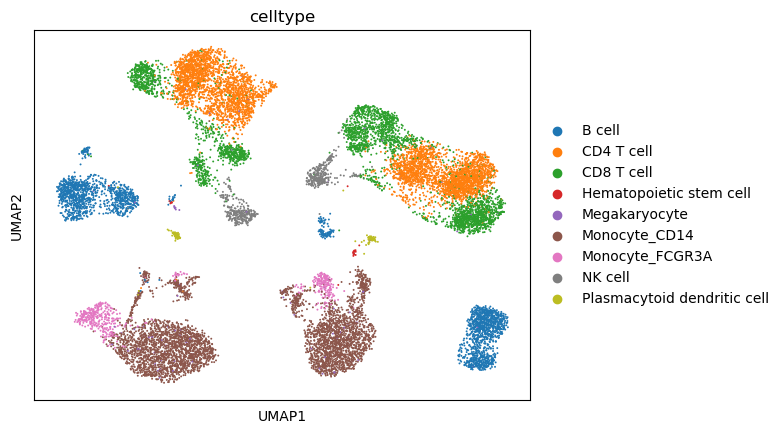

In [19]:
sc.pl.umap(pbmc_concat, color="batch") # The color parameter indicates which .obs column to use for plotting
sc.pl.umap(pbmc_concat, color="celltype")

From here, we can clearly see the technical effect - the two batches are not clustering together, even though the cell-types (classes) overlap between them. The **goal of horizontal integration** is to undo the mapping caused by technical effects, such that the two batches do overlap based on their shared classes/cell-types. 

To exhibit how a batch-correction method works, we'll employ the Harmony batch-correction technique. 

In [22]:
# Call the harmony integration function - this takes the PCA space (we already computed above)
# and uses that data and the batch covariate (which we have as 'batch' in .obs) to integrate
# the data and results in an attribute called ["X_pca_harmony"] in the .obsm property
sc.external.pp.harmony_integrate(
    pbmc_concat,
    key = "batch"
)
pbmc_concat.obsm["X_pca_harmony"].shape

2022-11-04 01:26:21,580 - harmonypy - INFO - Iteration 1 of 10
2022-11-04 01:26:25,998 - harmonypy - INFO - Iteration 2 of 10
2022-11-04 01:26:30,518 - harmonypy - INFO - Iteration 3 of 10
2022-11-04 01:26:34,925 - harmonypy - INFO - Iteration 4 of 10
2022-11-04 01:26:37,721 - harmonypy - INFO - Iteration 5 of 10
2022-11-04 01:26:38,998 - harmonypy - INFO - Iteration 6 of 10
2022-11-04 01:26:40,298 - harmonypy - INFO - Iteration 7 of 10
2022-11-04 01:26:41,581 - harmonypy - INFO - Converged after 7 iterations


(15476, 20)

Now we have a corrected embedding which replaces the PCA of the base (uncorrected) embedding. 

This embedding can be treated as "corrected PCA" data. We'll do the same thing when we work on our own method for integration - we want to obtain an embedding that has integrated the data.

From here, we can redo steps 5 and 6 outlined above using this corrected embedding:

In [23]:
sc.pp.neighbors(pbmc_concat, n_neighbors=15, use_rep="X_pca_harmony") # Get the neighborhood graph of the Harmony-corrected PCA space
sc.tl.umap(pbmc_concat) # Use the neighborhood graph to get the UMAP coordinates

Now let's examine the same visualizations as before using the UMAP of the corrected/integrated data

/h/hmaan/miniconda3/envs/single_cell_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


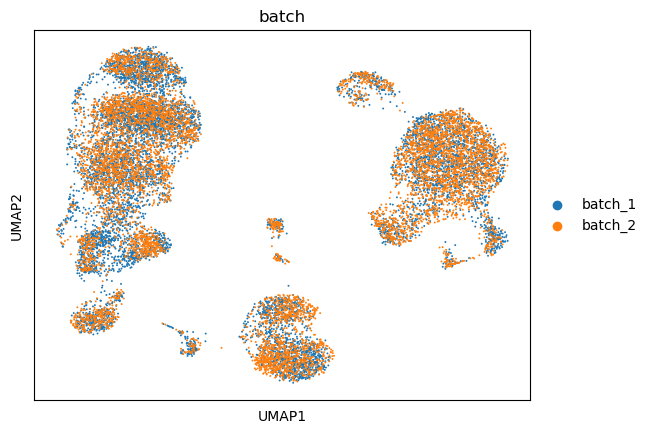

/h/hmaan/miniconda3/envs/single_cell_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


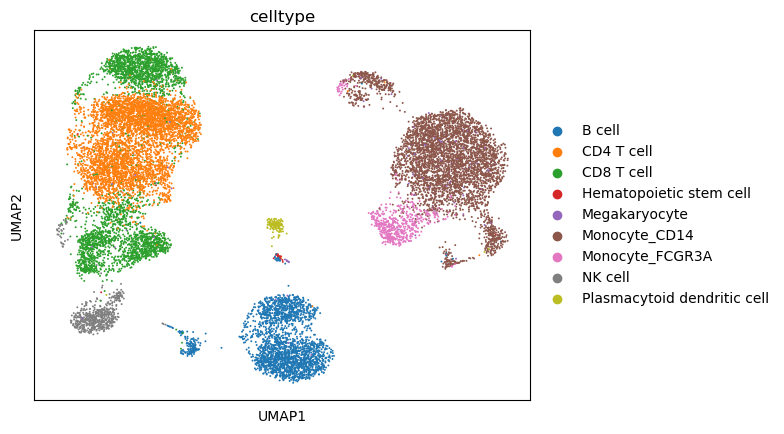

In [24]:
sc.pl.umap(pbmc_concat, color="batch") # The color parameter indicates which .obs column to use for plotting
sc.pl.umap(pbmc_concat, color="celltype")

As we can see now, after integration, the batches are clearly overlapping based on the ground-truth cell-types.

The integration by Harmony has effectively undone the mapping caused by the technical effects. 

If we did not have the cell-type labels, and we were to cluster this data, we would get a good correspondence of the clusters with the ground-truth cell-types because the batches are overlapping.

In the unintegrated case, this would not be true because the batches are sharply separted by the technical effects.
The next notebook will outline how to benchmark/score the results of integration.